In [2]:
import pandas as pd
import os
import re
from Bio import SeqIO
import subprocess 
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

%matplotlib inline

In [13]:
#deduplicate
HiseqData='/nasdata/Vincent/HISEQ_ARAZ_Jan14_2019/try3/AR_AZ_eDNA_Library_S1_R1_001.fastq.gz'
subprocess.call(["clumpify.sh in="+HiseqData+" out="+HiseqData.replace('.gz','.clumped.gz')+" dedupe subs=2"], shell= True)

#remove E.coli and vector reads
vector_ecoli='/nasdata/Neev/pacbio_data/VL/ecoli_pWEB_TNC.fasta'
subprocess.call(["bbmap.sh in="+HiseqData.replace('.gz','.clumped.gz')+" ref="+vector_ecoli+" outu="+HiseqData.replace('.gz','.clumped.novector.bam')+" outm="+HiseqData.replace('.gz','.clumped.vectorColi.bam')+" maxindel=10 minid=0.95"], shell= True) 
subprocess.call(["samtools fastq "+HiseqData.replace('.gz','.clumped.novector.bam')+" > "+HiseqData.replace('.fastq.gz','.clumped.novector.fastq')], shell= True)


0

### align short reads on every sequence then calculate coverage individually


0
mean coverage = 0.588365164654


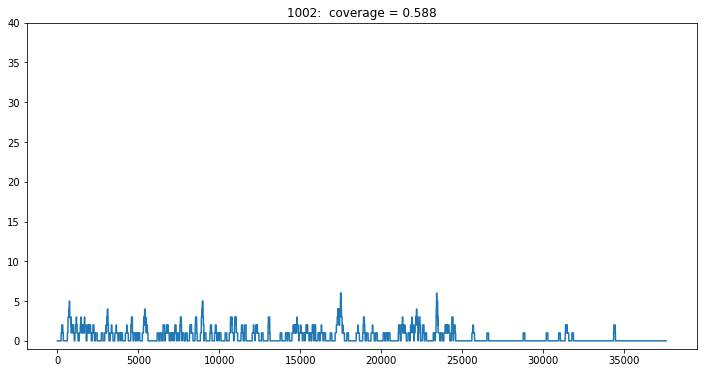

1002
mean coverage = 0.217215039676


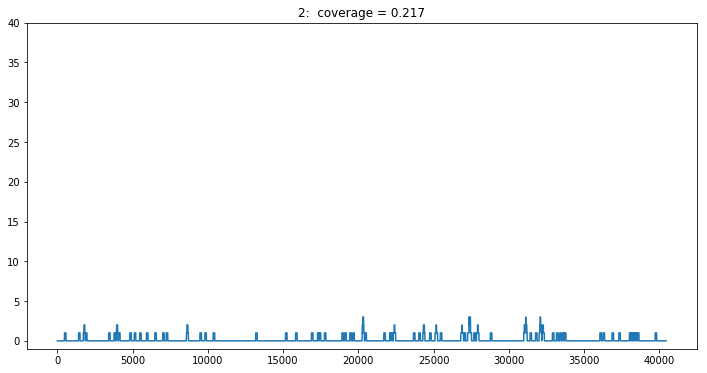

2
mean coverage = 0.461745549284


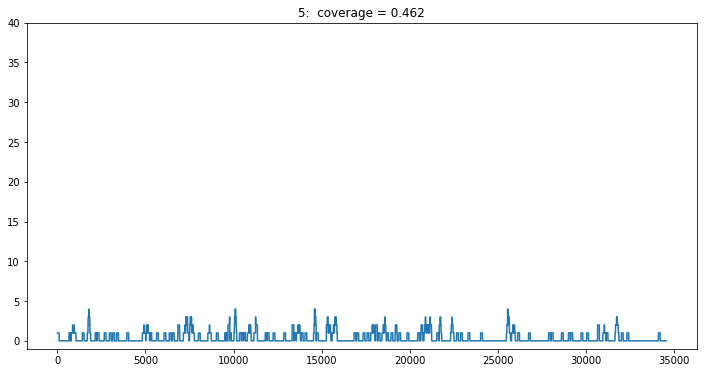

5
mean coverage = 0.267576416485


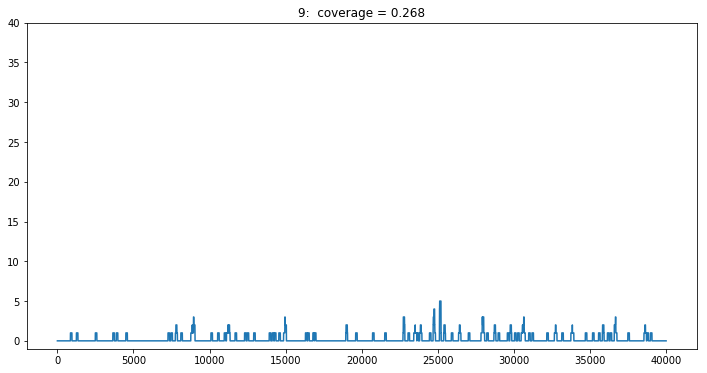

9
mean coverage = 0.52365521711


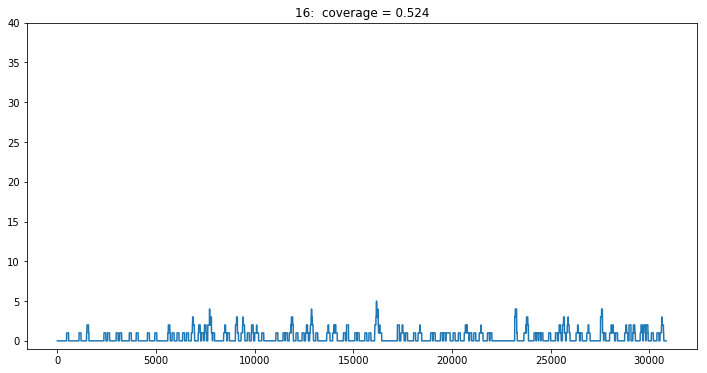

16
mean coverage = 0.50109453898


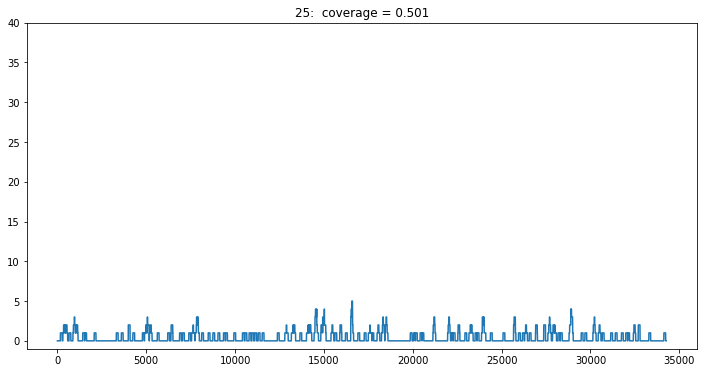

25
mean coverage = 0.546071255515


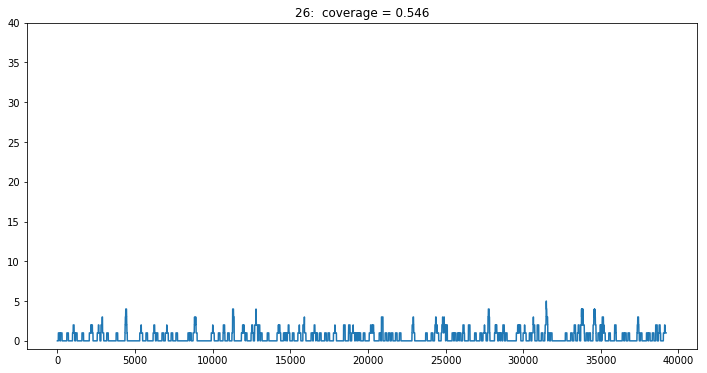

26
mean coverage = 0.222085858198


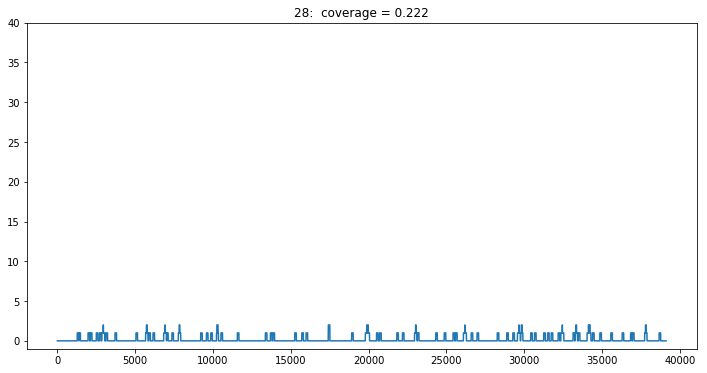

28
mean coverage = 0.277916087948


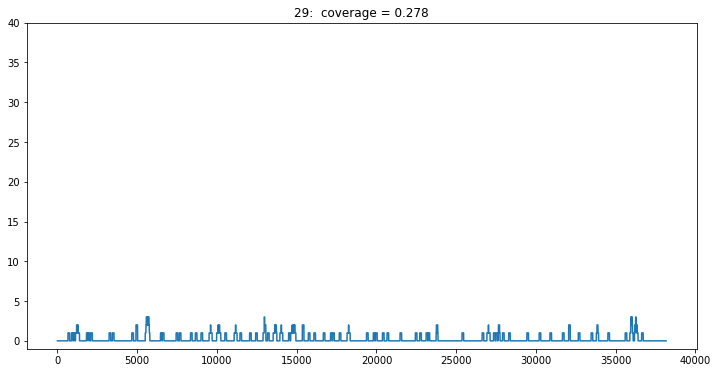

29
mean coverage = 0.664779096841


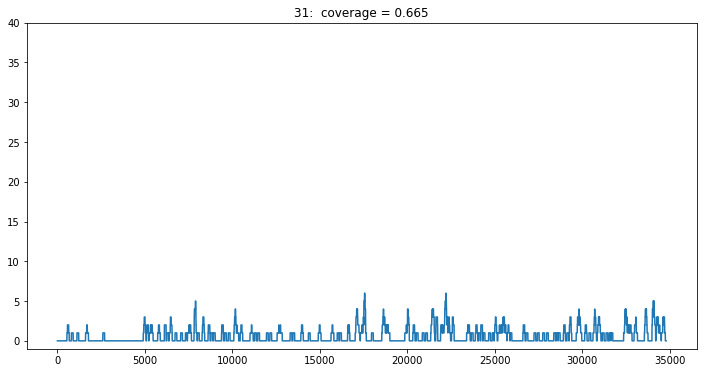

31
mean coverage = 0.191966080632


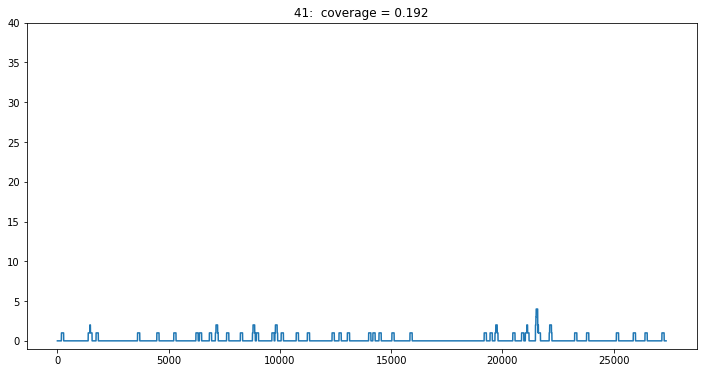

41
mean coverage = 0.359969521188


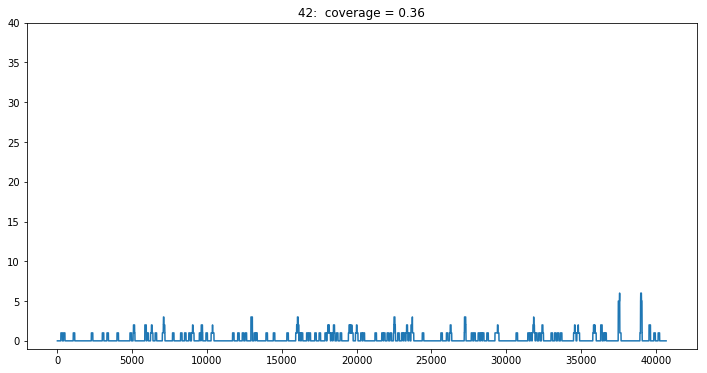

42
mean coverage = 0.198512870302


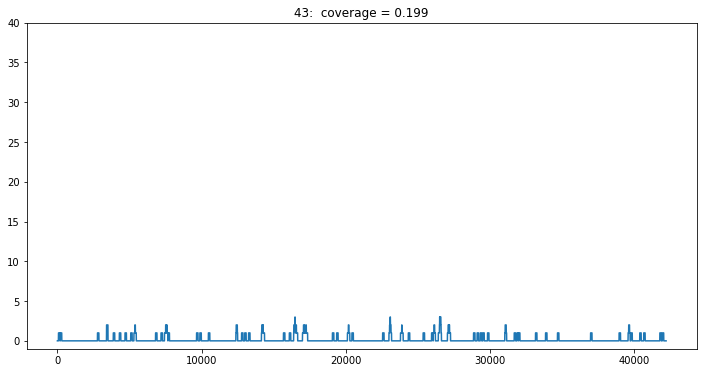

43
mean coverage = 0.412298975085


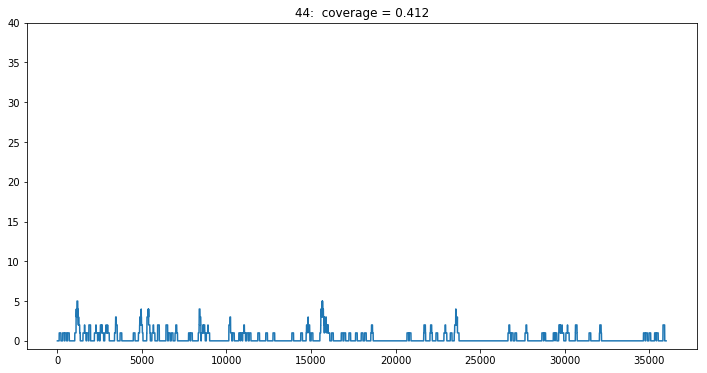

44
mean coverage = 0.0982132004376


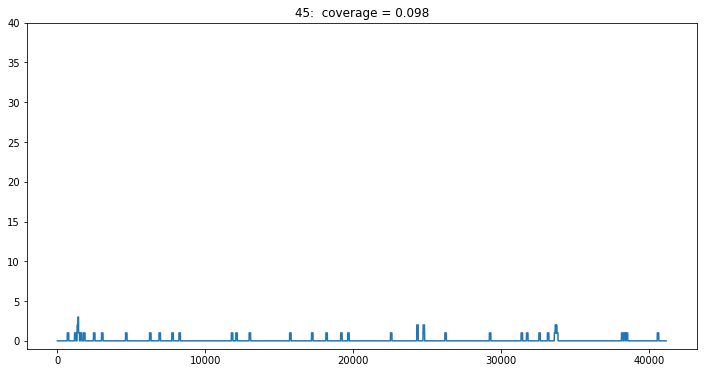

45
mean coverage = 0.777258735216


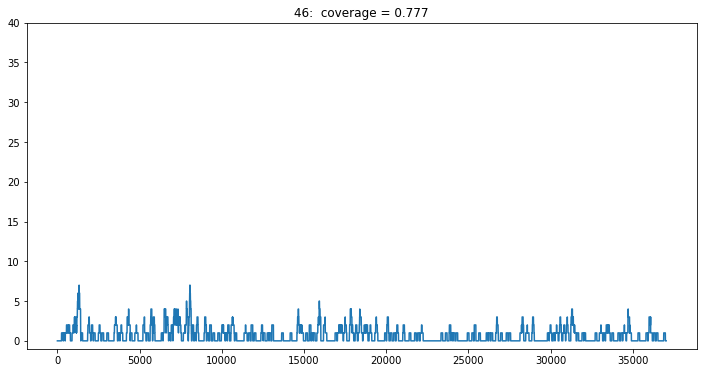

46
mean coverage = 0.168369119589


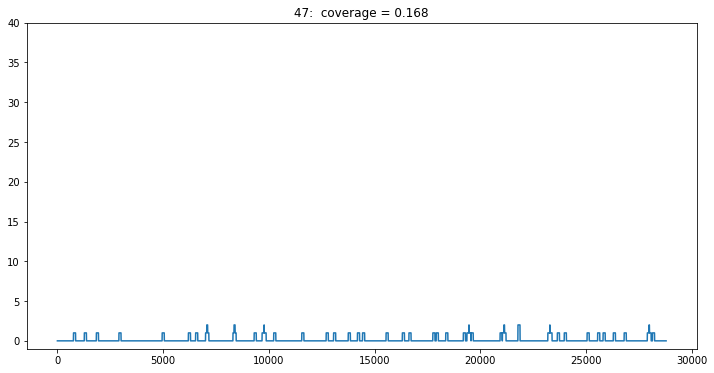

47
mean coverage = 0.261986180223


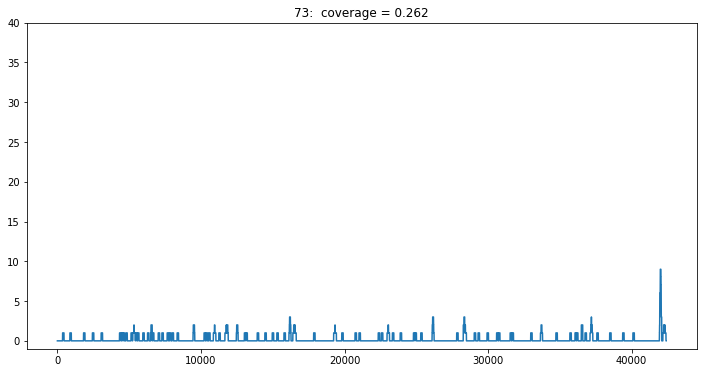

73
mean coverage = 0.749868312138


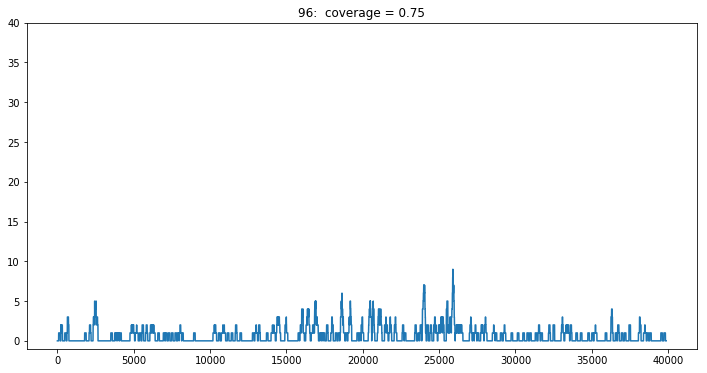

96
mean coverage = 0.131486917677


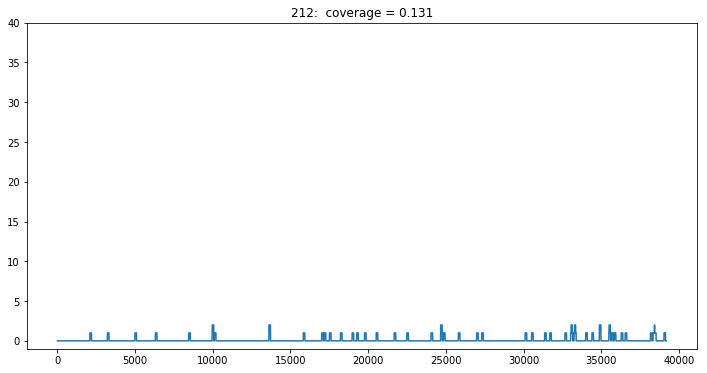

212
mean coverage = 0.0674304331571


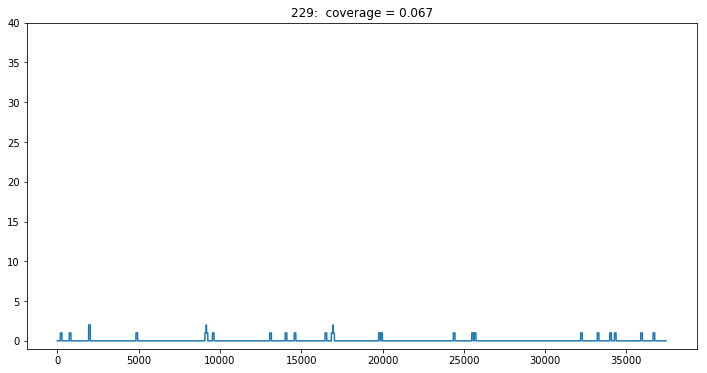

229
mean coverage = 0.143878635617


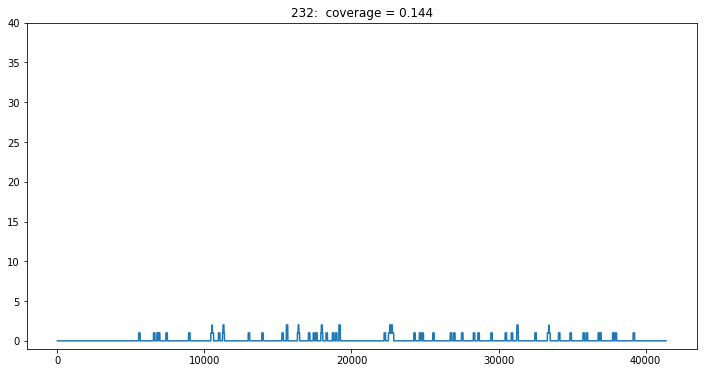

232
mean coverage = 1.39431576231


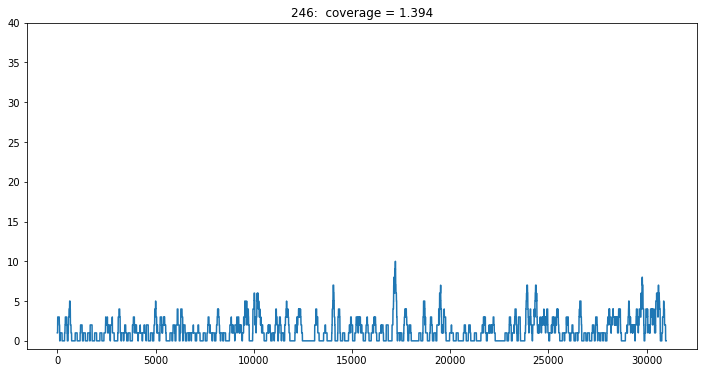

246
mean coverage = 0.0700740055504


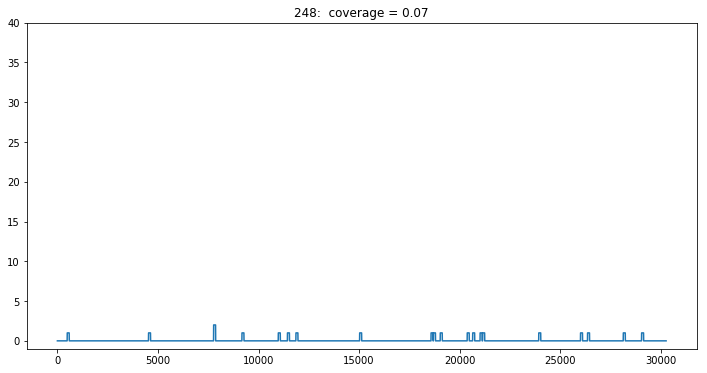

248
mean coverage = 0.212995290203


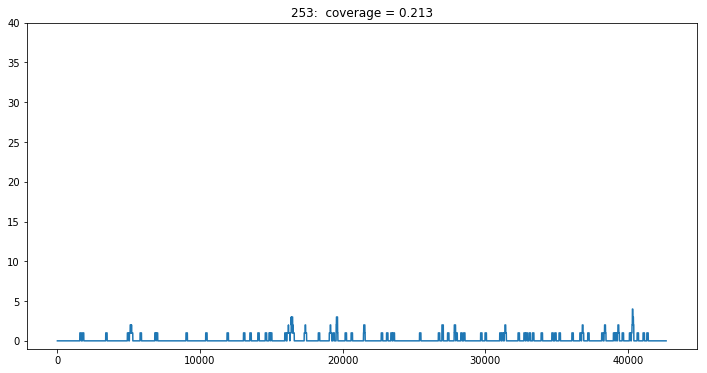

253
mean coverage = 0.223234624146


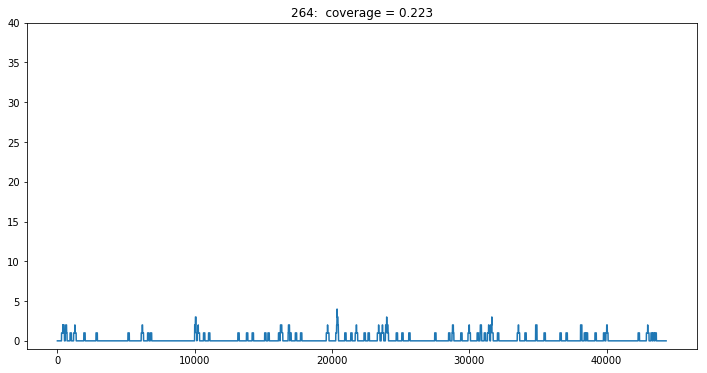

264
mean coverage = 0.510856750906


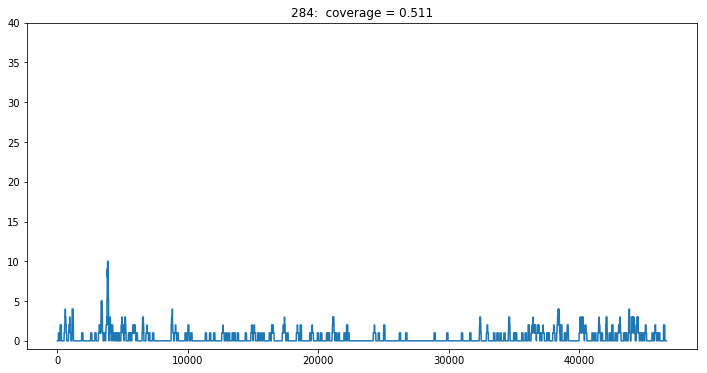

284
mean coverage = 0.40056383792


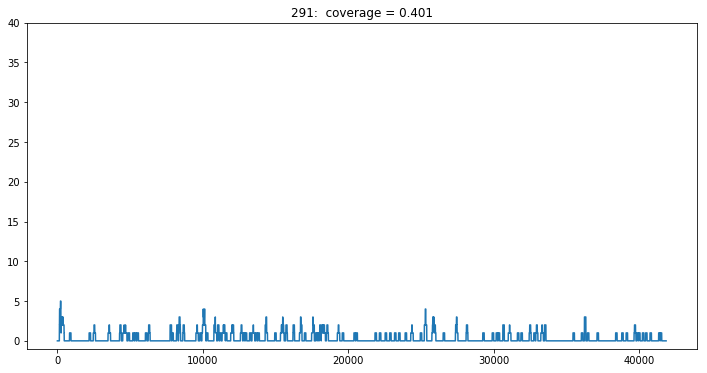

291
mean coverage = 0.138526973188


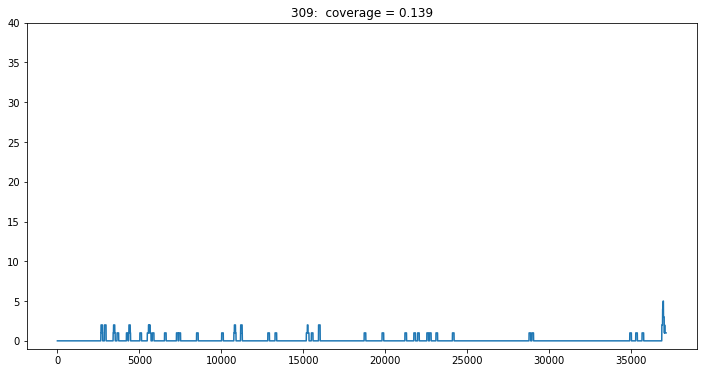

309
mean coverage = 0.269372801876


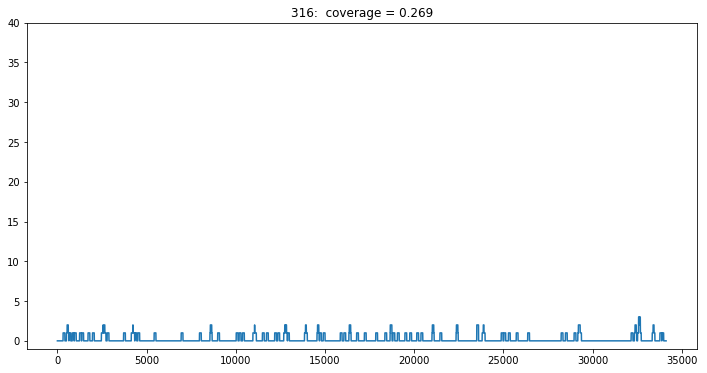

316
mean coverage = 0.0714791224345


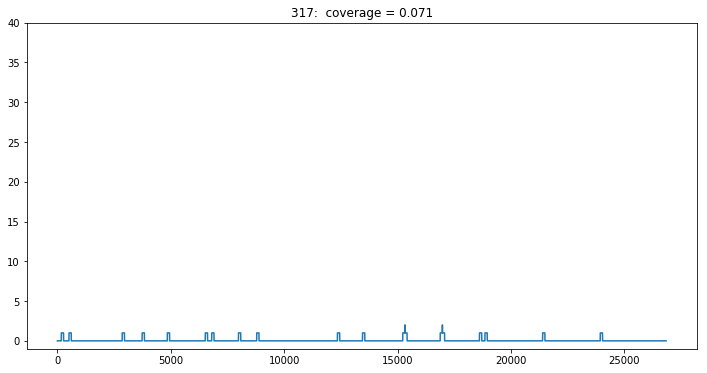

317
mean coverage = 0.281130387235


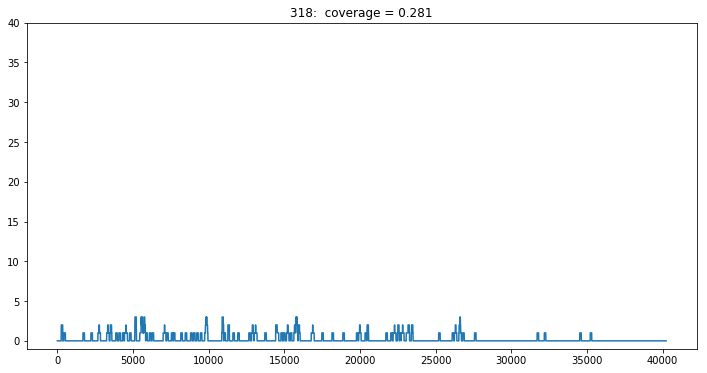

318
mean coverage = 0.120761148846


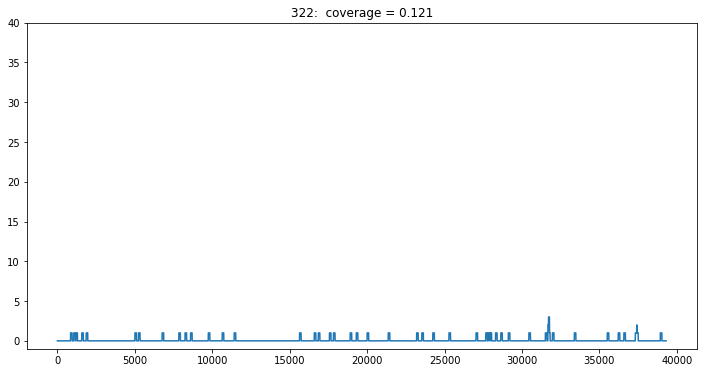

322
mean coverage = 0.495171782883


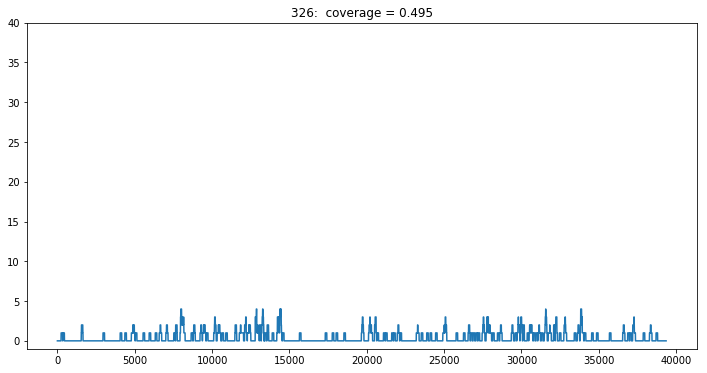

326
mean coverage = 0.412787486468


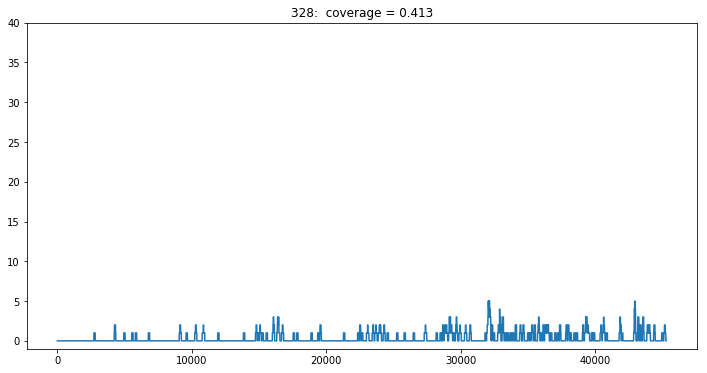

328
mean coverage = 0.22156585582


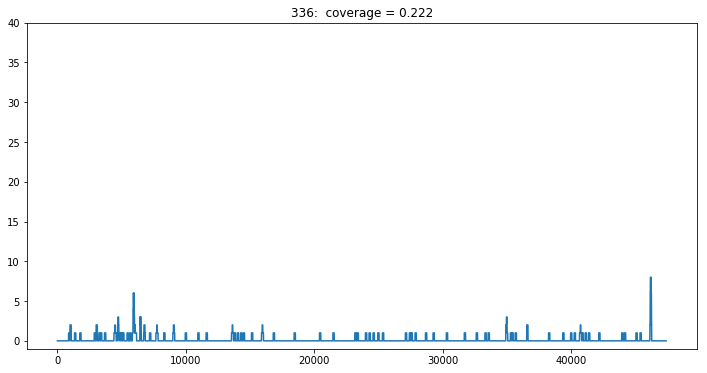

336
mean coverage = 0.872655939843


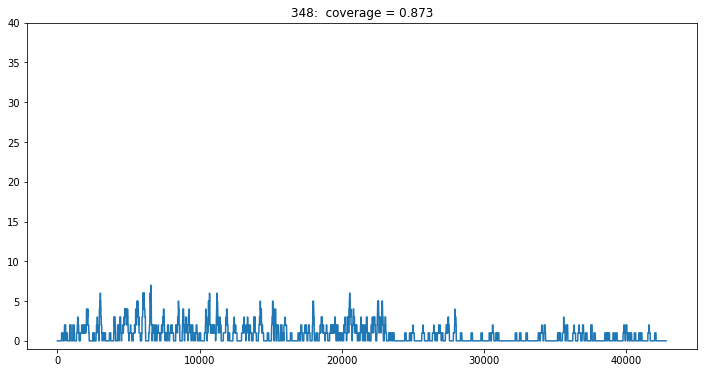

348
mean coverage = 0.145352446526


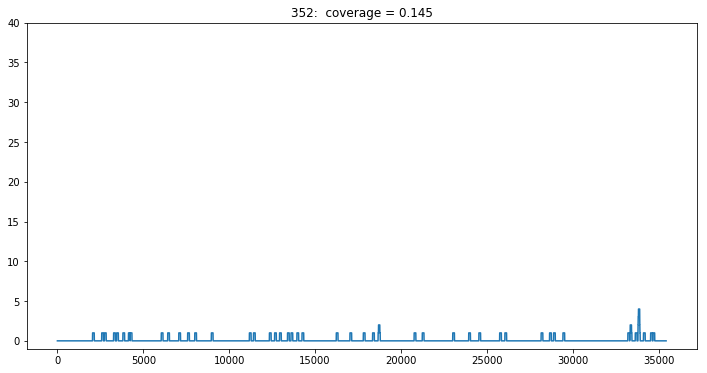

352
mean coverage = 0.598588963491


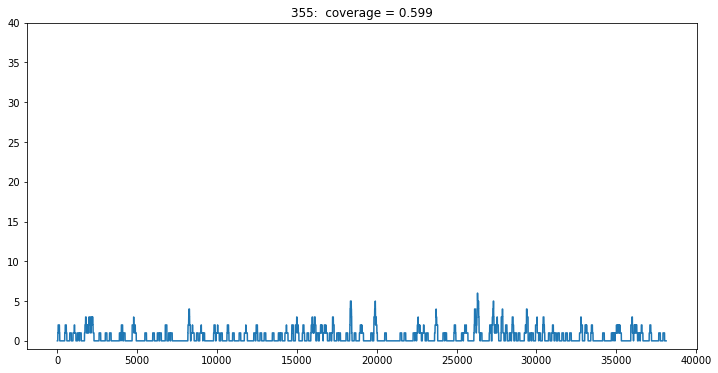

355
mean coverage = 0.413612703781


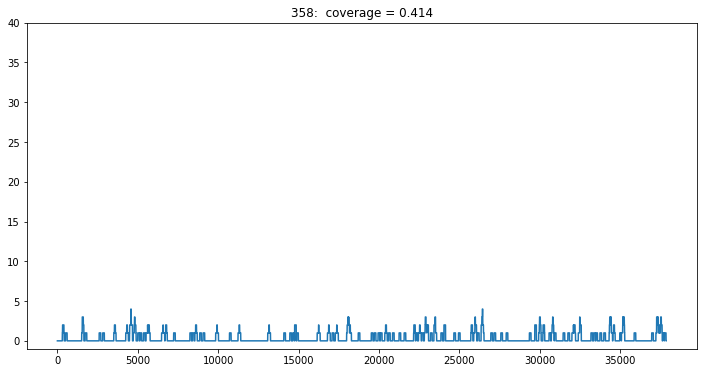

358
mean coverage = 0.9196501318


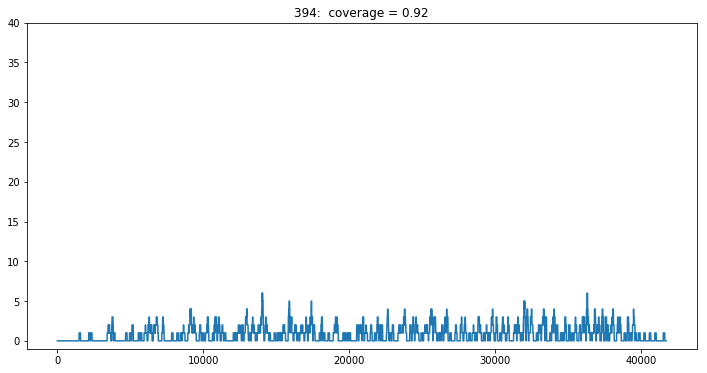

394
mean coverage = 1.34062950424


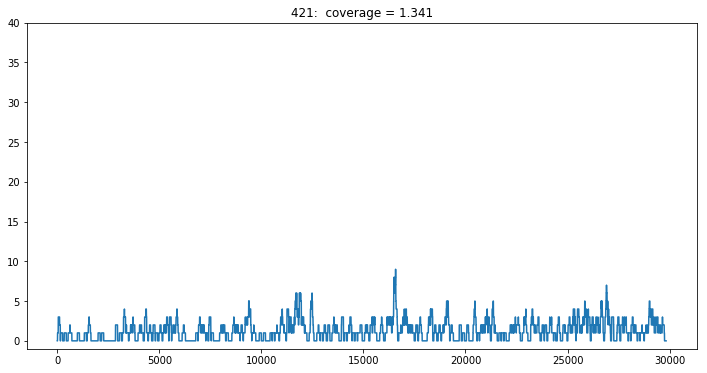

421
mean coverage = 0.185252199777


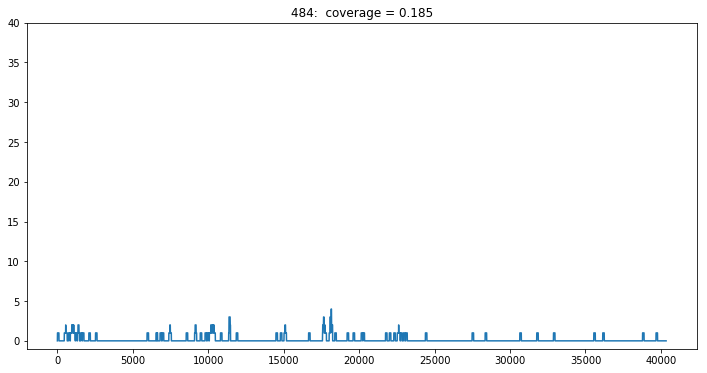

484
mean coverage = 0.36319324734


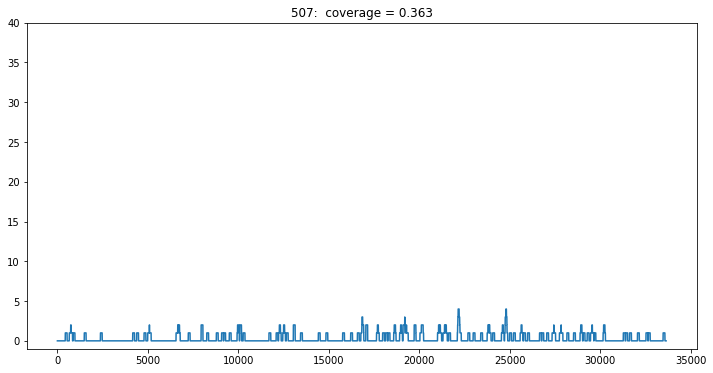

507
mean coverage = 0.980326671189


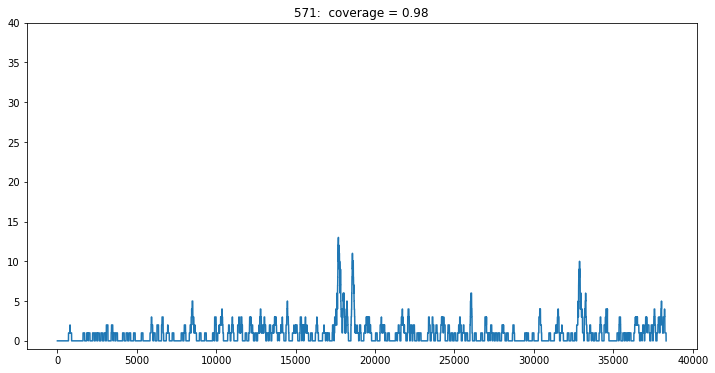

571
mean coverage = 0.458855025825


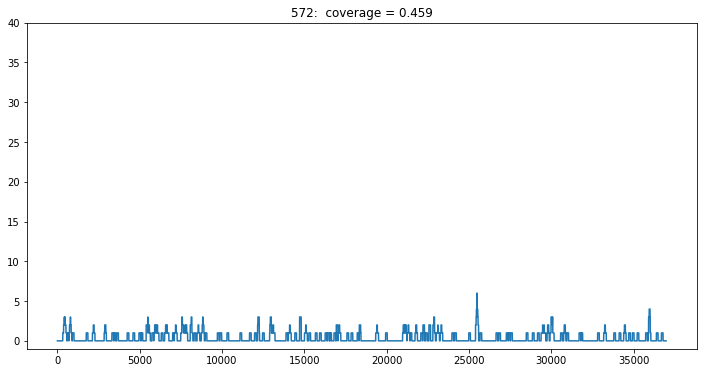

572
mean coverage = 0.193953692527


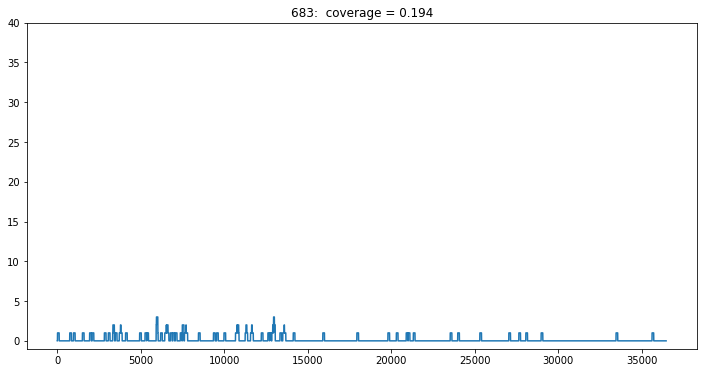

683
mean coverage = 0.357208284566


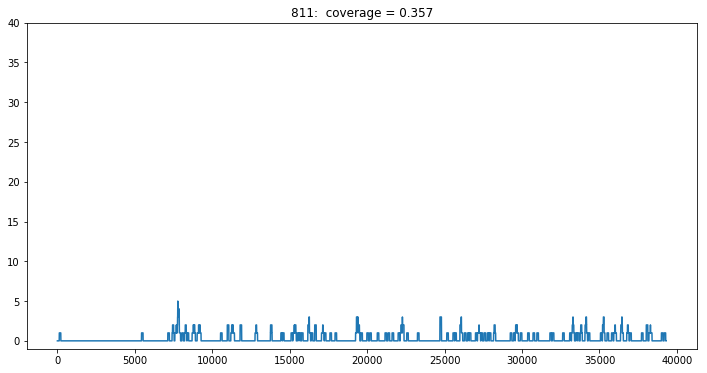

811
mean coverage = 0.0767677949738


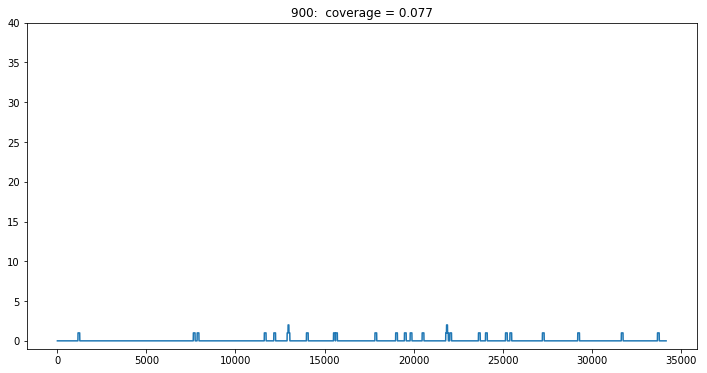

900
mean coverage = 0.167806073812


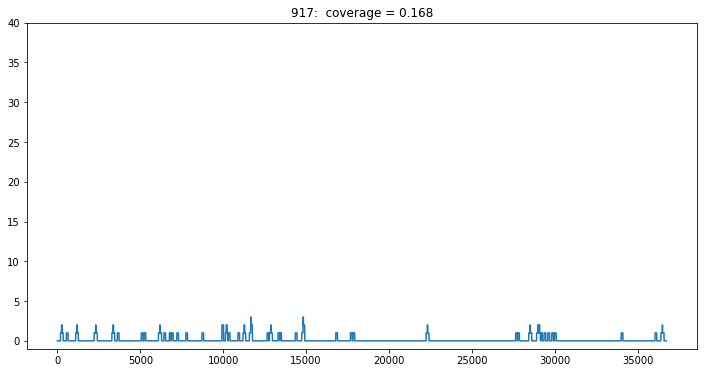

917
mean coverage = 0.248181161166


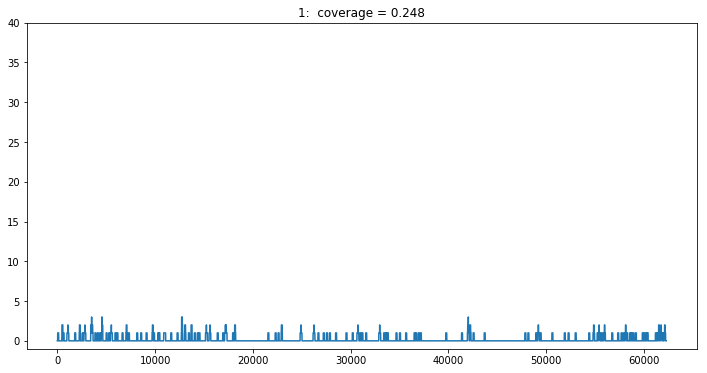

1
mean coverage = 0.269571396385


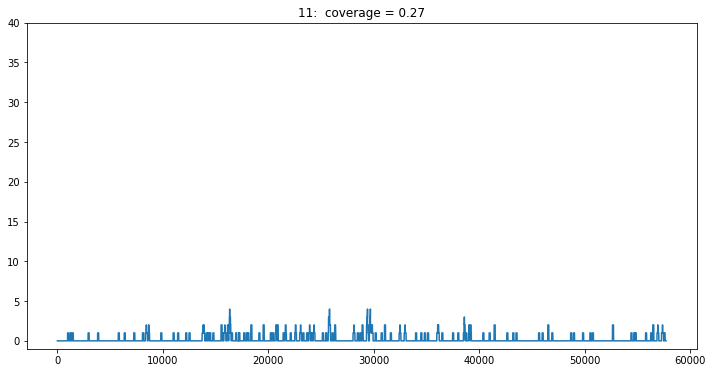

11
mean coverage = 0.264500772207


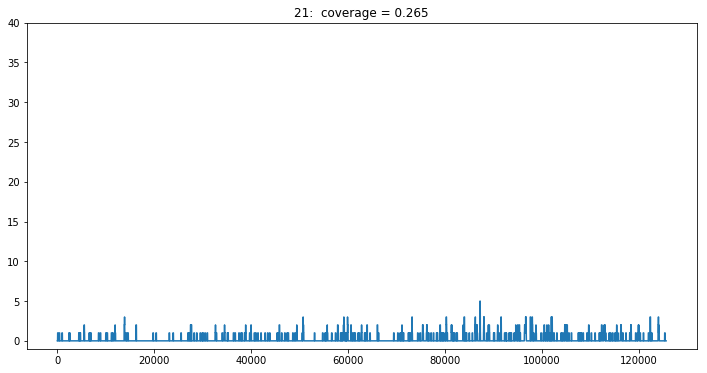

21
mean coverage = 0.464310424354


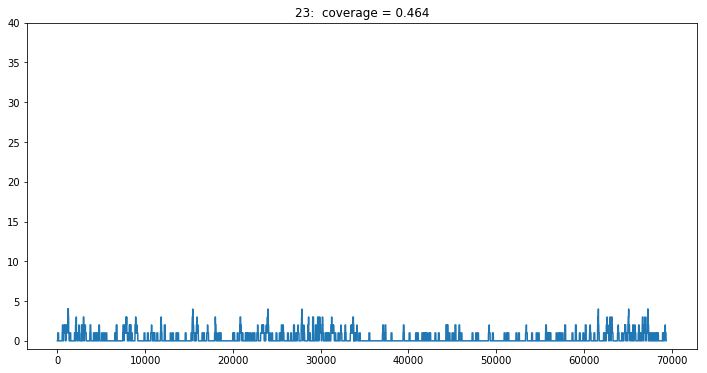

23
mean coverage = 0.33500287118


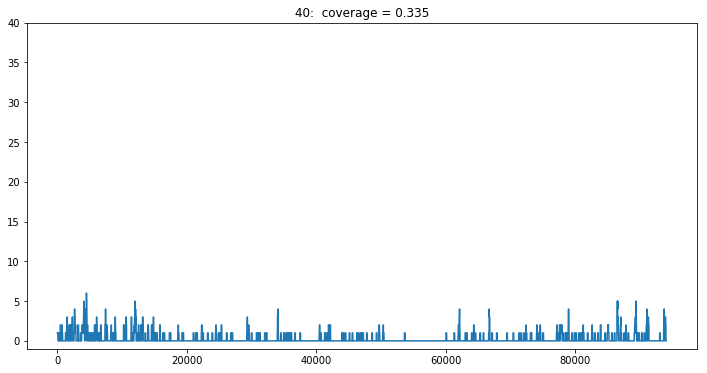

40
mean coverage = 0.179795647968


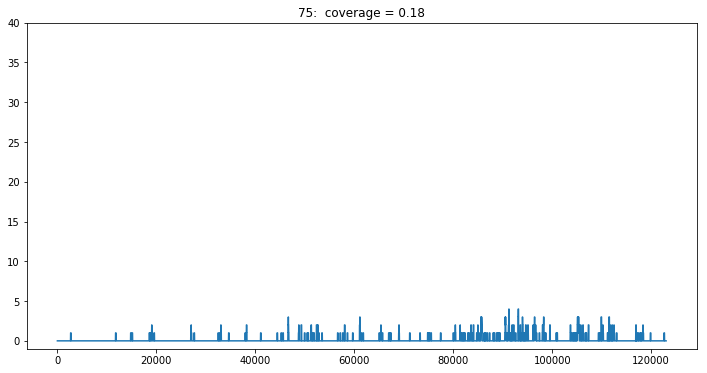

75
mean coverage = 0.300978224295


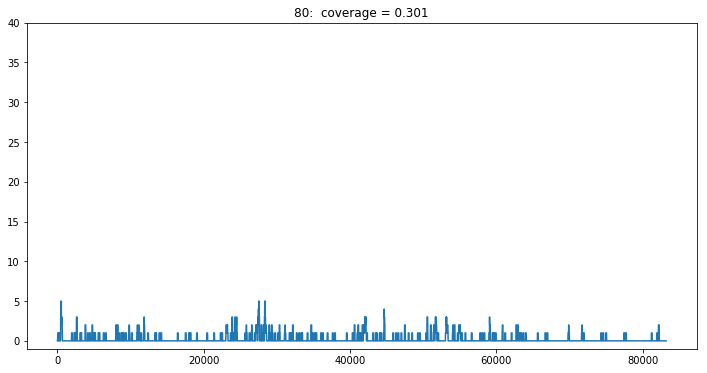

80
mean coverage = 0.316434094648


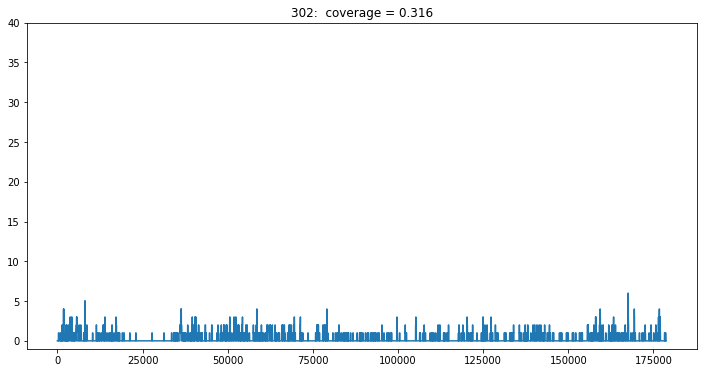

302
mean coverage = 0.63601011083


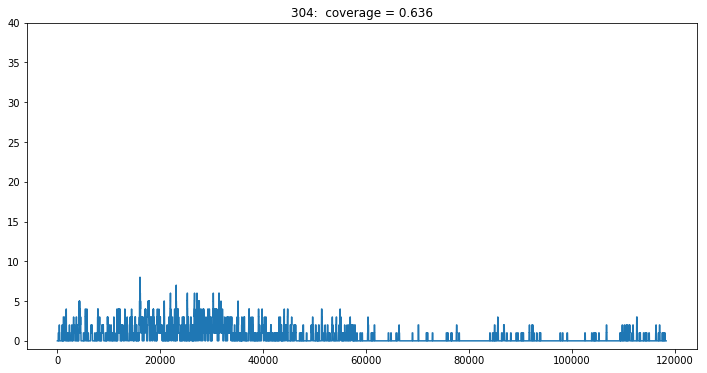

304
mean coverage = 0.306556469309


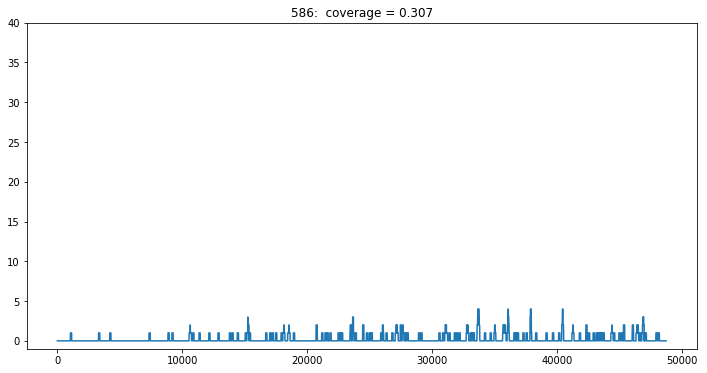

586
mean coverage = 0.755834291927


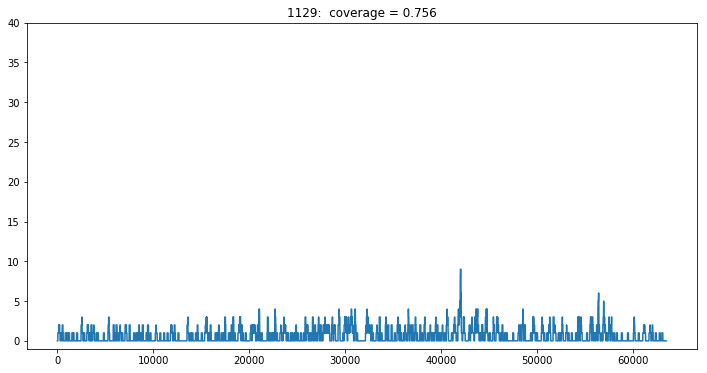

1129
mean coverage = 0.352606058893


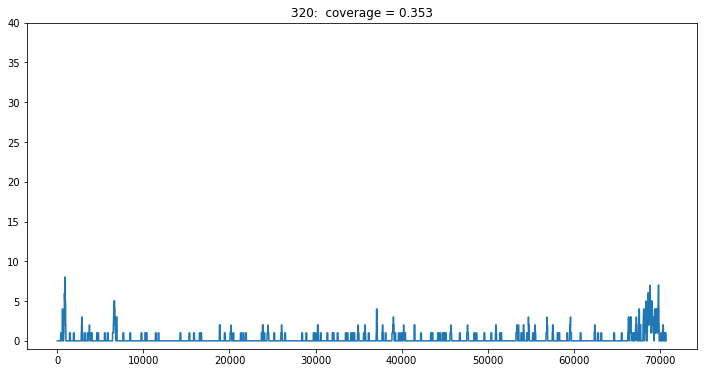

320
mean coverage = 1.23002225369


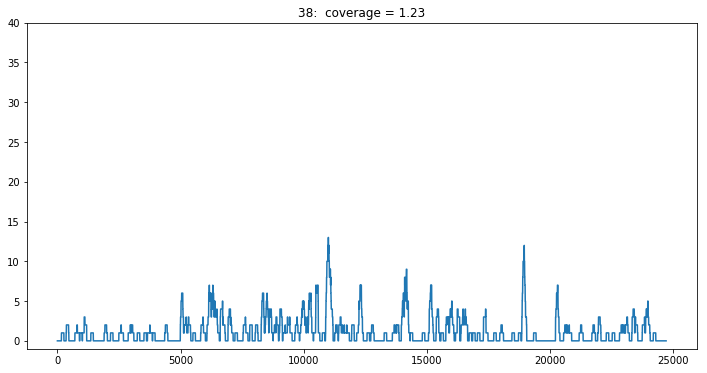

38
mean coverage = 0.158280022326


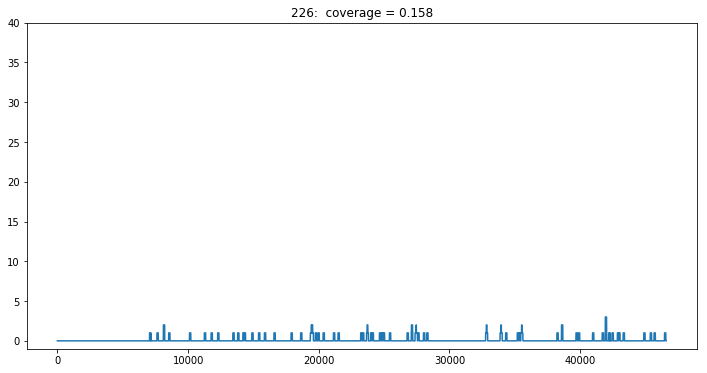

226
mean coverage = 0.442978608543


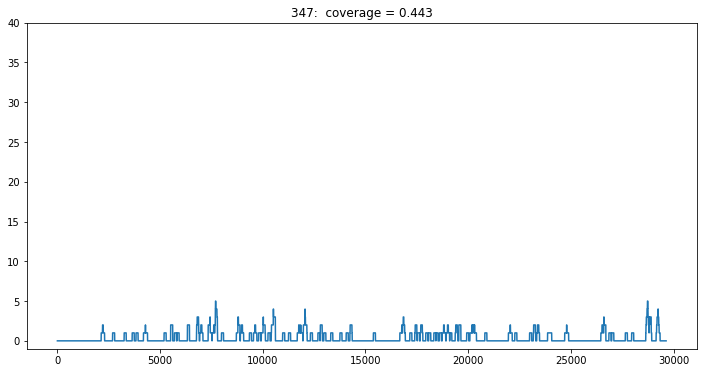

347
mean coverage = nan
666: No Hit, nothing to plot


In [6]:
HiseqData='/nasdata/Vincent/HISEQ_ARAZ_Jan14_2019/try3/AR_AZ_eDNA_Library_S1_R1_001.clumped.novector.fastq'
targetsFolder='/nasdata/Vincent/abundance/batched_contigs/'

os.chdir('/nasdata/Vincent/abundance/BBalignments/')

subprocess.call(["cat "+targetsFolder+"*.fasta > "+targetsFolder+"ALLrecovered.fa"], shell= True)


targetList=[]
for filename in os.listdir(targetsFolder): 
    if filename.endswith(".fasta"):
        targetList.append(filename[:-6].split('.')[0].split('_')[0])  #for recovered cosmids
        #targetList.append(filename[:-6])  # for PACBIO contigs


abundanceDF=pd.DataFrame()
abundanceDF['meanCoverage']=''
abundanceDF['stdev']=''

if not os.path.exists("ALL.mapped.bam"):
    subprocess.call(["bbmap.sh in="+HiseqData+" ref="+targetsFolder+"ALLrecovered.fa outm=ALL.mapped.bam maxindel=10 minid=0.95 ambig=all secondary=t saa=f ssao=t sssr=0.95"], shell= True) #ambig=all
    subprocess.call(["samtools sort -@ 60 ALL.mapped.bam -o ALL.sorted.bam"], shell= True)
    subprocess.call(["samtools index ALL.sorted.bam"], shell= True)

##loop to generate all individual bamfiles for each target
for idx,target in enumerate(targetList):
    if idx%100==0:
        print ('')
        print (idx)
    subprocess.call(["samtools view -h -o "+target+".sam ALL.sorted.bam '"+target+"'"], shell= True)    
 
    with open(target+".only.sam",'w') as outfile:
        with open(target+".sam",'rU') as infile:
            for line in infile:
                if line.startswith('@SQ'):
                    if 'SN:'+target+'\t' in line:
                        outfile.write(line)
                else:
                    outfile.write(line)
    
    # get histogram of coverage for each basepair
    subprocess.call(["samtools view -b "+target+".only.sam | genomeCoverageBed -d -ibam stdin > "+target+".coveragePos.txt"], shell= True)
 
    
    covHistDF=pd.read_csv (target+".coveragePos.txt", names=['BGC','position','coverage'], sep='\t')
    meanCov=float("{0:.3f}".format(covHistDF.coverage.mean()))
    abundanceDF.loc[target,'meanCoverage']=meanCov
    abundanceDF.loc[target,'stdev']="{0:.3f}".format(covHistDF.coverage.std())

    print 'mean coverage = '+str(covHistDF.coverage.mean())


    #if covHistDF.coverage.mean() > 4:
    #plot hit sites histogram 
    try:
        fig=covHistDF.coverage.plot(figsize=(12,6),ylim =[-1,40])
        plt.title(target+':  coverage = '+str(meanCov))
        plt.show()
        print (target)
    except:
        print (target+': No Hit, nothing to plot')
abundanceDF.sort_values(by=['meanCoverage'],ascending=False,inplace=True)
abundanceDF['Gbps_x1Cov']=15.5/abundanceDF['meanCoverage']
abundanceDF['Tbps_x20Cov']=abundanceDF['Gbps_x1Cov']*20/1000.0
abundanceDF.to_csv('/nasdata/Vincent/abundance/Recovered_abundanceDF_May.csv')

####    Reads Used:           	153986896	(15552676496 bases)
= 15.5 Gbps

/ru-auth/local/home/vlibis/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


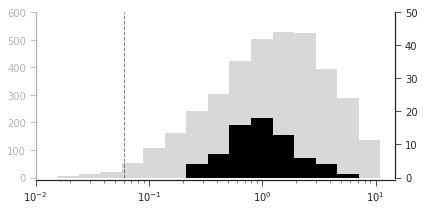

In [255]:
PACBIOabundance1=pd.read_csv('/nasdata/Vincent/abundance/PACBIOabundanceDF.csv')
PACBIOabundance2=pd.read_csv('/nasdata/Vincent/abundance/PACBIO_2249_abundanceDF.csv')
PACBIOabundance2=PACBIOabundance2.reset_index(drop=True)
PACBIOabundance=pd.concat([PACBIOabundance1, PACBIOabundance2], ignore_index=True)
PACBIOabundance=PACBIOabundance.query('meanCoverage > 0.03')
RECOVEREDabundance=pd.read_csv('/nasdata/Vincent/abundance/Recovered_abundanceDF.csv')
#PACBIONETWORKSabundance=pd.read_csv('/nasdata/Vincent/abundance/PACBIOnetworks_abundanceDF.csv')
#CONCATENATE PACBIOnetworks and RECOVEREDabundance DFs

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
fig = plt.figure(figsize=(6,3))

ax1 = plt.subplot(111)
cnt, bins, patches = ax1.hist(PACBIOabundance['Tbps_x20Cov'].tolist(),bins=np.logspace(np.log10(0.01),np.log10(11.0),17) ,color='grey', alpha=0.3)
ax1.set_xlim(0.01,15)
ax2 = ax1.twinx()
ax2.grid('off')
cnt, bins, patches = ax2.hist(RECOVEREDabundance['Tbps_x20Cov'].tolist(),bins=np.logspace(np.log10(0.01),np.log10(11.0), 17) ,color='k', alpha=1)
ax2.set_ylim(0,50)
ax1.set_ylim(0,600)

ax1.axvline(x=0.06, color='k', linestyle='dashed', linewidth=1, alpha=0.5)  #human genome line
plt.xscale('log')
plt.xlabel('Tbps')
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.spines['left'].set_color('#b2b2b2')
ax1.tick_params(axis='y', colors='#b2b2b2')
plt.tight_layout()
sns.despine(ax=ax1,offset={'bottom':2});
fig.savefig('/nasdata/Vincent/abundance/abundance3.png', transparent=True, dpi=300)


In [264]:
RECOVEREDabundance.Tbps_x20Cov.mean()

1.2572078119186116